In [1]:
!git clone https://github.com/anantgupta129/ERA-V1.git
%cd ERA-V1/easytorch/

Cloning into 'ERA-V1'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (383/383), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 383 (delta 210), reused 309 (delta 137), pack-reused 0
Receiving objects: 100% (383/383), 2.93 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (210/210), done.
/content/ERA-V1/easytorch


In [2]:
!python setup.py sdist
!pip install .

running sdist
running egg_info
creating easytorch.egg-info
writing easytorch.egg-info/PKG-INFO
writing dependency_links to easytorch.egg-info/dependency_links.txt
writing requirements to easytorch.egg-info/requires.txt
writing top-level names to easytorch.egg-info/top_level.txt
writing manifest file 'easytorch.egg-info/SOURCES.txt'
reading manifest file 'easytorch.egg-info/SOURCES.txt'
writing manifest file 'easytorch.egg-info/SOURCES.txt'
running check
creating easytorch-0.1
creating easytorch-0.1/easytorch
creating easytorch-0.1/easytorch.egg-info
creating easytorch-0.1/easytorch/models
creating easytorch-0.1/easytorch/utils
copying files to easytorch-0.1...
copying README.md -> easytorch-0.1
copying setup.py -> easytorch-0.1
copying easytorch/__init__.py -> easytorch-0.1/easytorch
copying easytorch/dataset.py -> easytorch-0.1/easytorch
copying easytorch/trainer.py -> easytorch-0.1/easytorch
copying easytorch.egg-info/PKG-INFO -> easytorch-0.1/easytorch.egg-info
copying easytorch.egg

In [3]:
%cd /content/

/content


In [4]:
import torch
from torchvision import transforms as T

import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

from easytorch.models.custom_resnet import ResNet18
from easytorch.dataset import build_cifar

# Load Data

In [5]:
batch_size = 512

kwargs = {
    "batch_size": batch_size,
    "shuffle": True,
    "num_workers": 2,
    "pin_memory": True,
}
mean = (0.49139968, 0.48215841, 0.44653091)
std = (0.24703223, 0.24348513, 0.26158784)
train_transforms = A.Compose(
    [
        A.Sequential(
            [
                A.CropAndPad(px=4, keep_size=False),  # padding of 2, keep_size=True by defaulf
                A.RandomCrop(32, 32),
            ]
        ),
        A.CoarseDropout(1, 16, 16, 1, 16, 16, fill_value=mean, mask_fill_value=None),
        A.Normalize(mean, std),
        ToTensorV2(),
    ]
)
train_loader = build_cifar(set="train", augments=train_transforms, **kwargs)
test_loader = build_cifar(set="test", **kwargs)

100%|██████████| 170498071/170498071 [00:01<00:00, 97709040.34it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [7]:
model = ResNet18().to(device)
model.summarize(device, (1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 32, 32]           1,728
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─Sequential: 1-3                        [1, 64, 32, 32]           --
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-1                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 32, 32]           128
│    │    └─Conv2d: 3-3                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-4             [1, 64, 32, 32]           128
│    │    └─Sequential: 3-5              [1, 64, 32, 32]           --
│    └─BasicBlock: 2-2                   [1, 64, 32, 32]           --
│    │    └─Conv2d: 3-6                  [1, 64, 32, 32]           36,864
│    │    └─BatchNorm2d: 3-7             [1, 64, 32, 32]           

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.63E-02


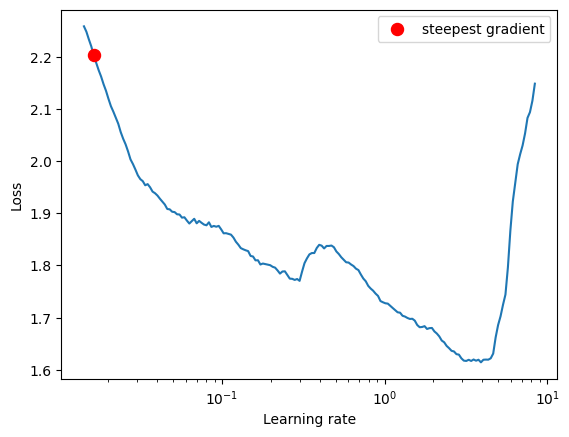

In [9]:
from torch.nn import CrossEntropyLoss
from easytorch.utils.misc import find_lr

model = ResNet18().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

kwargs = {"end_lr": 10, "num_iter": 200, "step_mode": "exp"}
find_lr(model, device, optimizer, criterion=CrossEntropyLoss(), dataloader=train_loader, **kwargs)

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
from easytorch.trainer import Trainer


num_epochs = 20

scheduler = OneCycleLR(
    optimizer,
    max_lr=1.63e-02,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    pct_start=5 / num_epochs,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy="linear",
)

# scheduler = None
trainer = Trainer(model, device, optimizer, scheduler)
for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}")
    trainer.train(train_loader)
    trainer.evaluate(test_loader)

Epoch 1


Train: Loss=1.6161 Batch_id=97 Accuracy=26.55: 100%|██████████| 98/98 [00:53<00:00,  1.83it/s]


Test set: Average loss: 1.6481, Accuracy: 4108/10000 (41.08%)

Epoch 2


Train: Loss=1.3659 Batch_id=97 Accuracy=46.14: 100%|██████████| 98/98 [00:52<00:00,  1.87it/s]


Test set: Average loss: 1.5789, Accuracy: 4711/10000 (47.11%)

Epoch 3


Train: Loss=1.1336 Batch_id=97 Accuracy=56.11: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 1.0448, Accuracy: 6248/10000 (62.48%)

Epoch 4


Train: Loss=0.9943 Batch_id=97 Accuracy=62.28: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.9026, Accuracy: 6822/10000 (68.22%)

Epoch 5


Train: Loss=0.8006 Batch_id=97 Accuracy=68.78: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.9328, Accuracy: 6818/10000 (68.18%)

Epoch 6


Train: Loss=0.7319 Batch_id=97 Accuracy=71.95: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.9435, Accuracy: 6849/10000 (68.49%)

Epoch 7


Train: Loss=0.7869 Batch_id=97 Accuracy=75.16: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.7373, Accuracy: 7585/10000 (75.85%)

Epoch 8


Train: Loss=0.5485 Batch_id=97 Accuracy=77.19: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.6381, Accuracy: 7891/10000 (78.91%)

Epoch 9


Train: Loss=0.5255 Batch_id=97 Accuracy=79.46: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.6495, Accuracy: 7936/10000 (79.36%)

Epoch 10


Train: Loss=0.5195 Batch_id=97 Accuracy=80.86: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.5878, Accuracy: 8077/10000 (80.77%)

Epoch 11


Train: Loss=0.5299 Batch_id=97 Accuracy=82.08: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.9383, Accuracy: 7448/10000 (74.48%)

Epoch 12


Train: Loss=0.4754 Batch_id=97 Accuracy=83.38: 100%|██████████| 98/98 [00:52<00:00,  1.85it/s]


Test set: Average loss: 0.5664, Accuracy: 8195/10000 (81.95%)

Epoch 13


Train: Loss=0.3886 Batch_id=97 Accuracy=84.57: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.5520, Accuracy: 8214/10000 (82.14%)

Epoch 14


Train: Loss=0.4498 Batch_id=97 Accuracy=85.64: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4675, Accuracy: 8518/10000 (85.18%)

Epoch 15


Train: Loss=0.3586 Batch_id=97 Accuracy=86.59: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.5153, Accuracy: 8378/10000 (83.78%)

Epoch 16


Train: Loss=0.3377 Batch_id=97 Accuracy=87.50: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.5388, Accuracy: 8406/10000 (84.06%)

Epoch 17


Train: Loss=0.2889 Batch_id=97 Accuracy=88.72: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.4663, Accuracy: 8603/10000 (86.03%)

Epoch 18


Train: Loss=0.2910 Batch_id=97 Accuracy=89.71: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.3819, Accuracy: 8851/10000 (88.51%)

Epoch 19


Train: Loss=0.2635 Batch_id=97 Accuracy=90.64: 100%|██████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.3666, Accuracy: 8863/10000 (88.63%)

Epoch 20


Train: Loss=0.2258 Batch_id=97 Accuracy=91.48: 100%|██████████| 98/98 [00:53<00:00,  1.84it/s]


Test set: Average loss: 0.3268, Accuracy: 8979/10000 (89.79%)



Set	 Max Acc@Epoch	 Last Epoch Acc
train	 91.48@20		91.48
test	 89.79@20		89.79


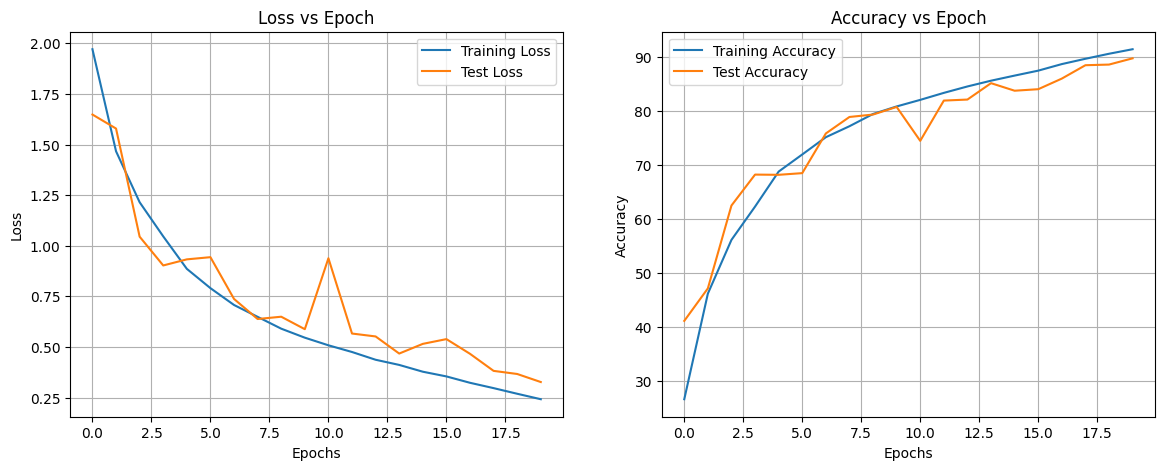

In [12]:
trainer.plot_history()

# Evaluate

In [11]:
from easytorch.dataset import make_transform
from easytorch.utils.misc import per_class_accuracy
from easytorch.utils.plotting import plot_misclassified

test_transforms = make_transform("test")

In [13]:
per_class_accuracy(model, device, test_loader)

[x] Accuracy of ::
	[*] airplane : 83 %
	[*] automobile : 95 %
	[*]     bird : 82 %
	[*]      cat : 85 %
	[*]     deer : 90 %
	[*]      dog : 85 %
	[*]     frog : 100 %
	[*]    horse : 86 %
	[*]     ship : 94 %
	[*]    truck : 95 %


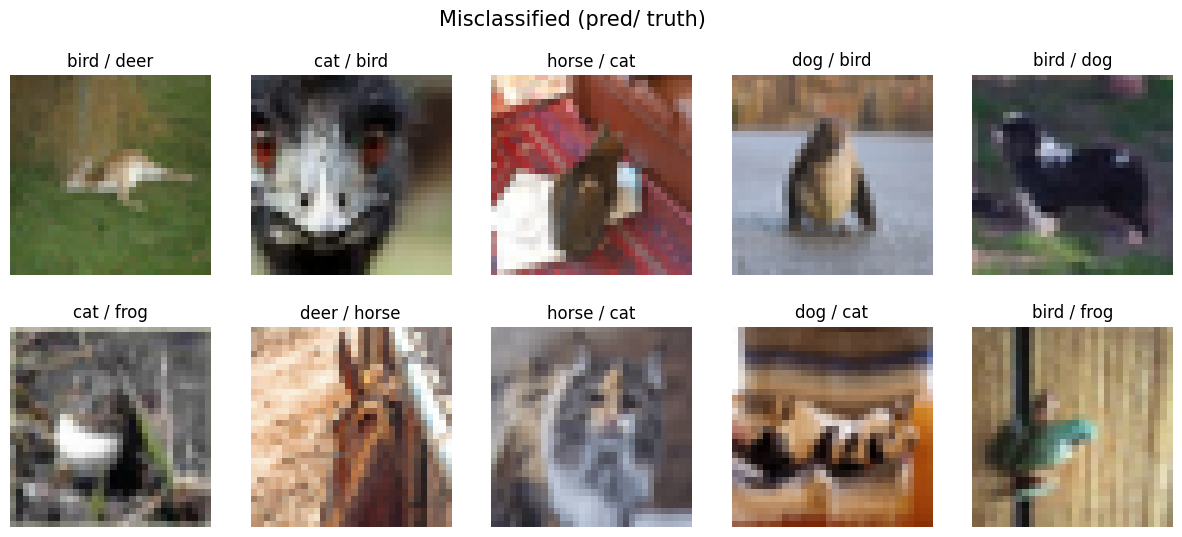

In [15]:
misclassified_imgs = plot_misclassified(
    model, test_loader, device, test_transforms, return_imgs=True
)

# GradCam Results

In [19]:
model.layer4[1]

BasicBlock(
  (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

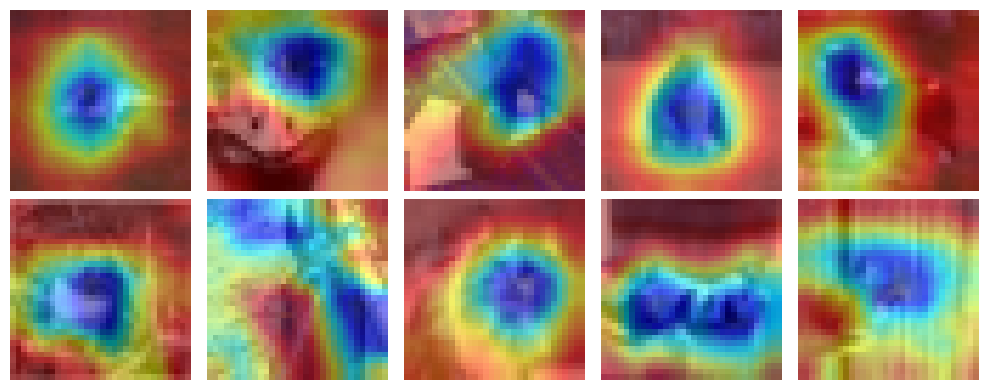

In [24]:
from easytorch.utils.gradcam import plot_cam_on_image

plot_cam_on_image(model, [model.layer4[1]], misclassified_imgs, {"mean": mean, "std": std})